## Setup

In [88]:
import torch
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import json
import os
import torch.nn as nn
import pickle
import tqdm
import time

In [89]:
# Check if PyTorch is using the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch is using: {device}")

# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Test a simple PyTorch tensor operation on the GPU
x = torch.tensor([2.0, 3.0], device=device)
y = torch.tensor([4.0, 5.0], device=device)
result = x * y
print(f"Result of tensor operation: {result}")

PyTorch is using: cpu
PyTorch version: 2.2.1+cpu
Result of tensor operation: tensor([ 8., 15.])


## Robustness on Normal ResNet 50

In [90]:
model = models.resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [91]:
LIMIT_PER_CLASS = 10000
STD = [0.1, 0.25, 0.5]

In [92]:
with open("imagenet_class_index.json", "r") as jf:
    class_index_json = json.load(jf)
print(class_index_json)

{'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'], '29': ['n01632777', 

In [93]:
class_indices = {}
for k, v in class_index_json.items():
    class_indices[v[0]] = int(k)
print(class_indices)

{'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9, 'n01530575': 10, 'n01531178': 11, 'n01532829': 12, 'n01534433': 13, 'n01537544': 14, 'n01558993': 15, 'n01560419': 16, 'n01580077': 17, 'n01582220': 18, 'n01592084': 19, 'n01601694': 20, 'n01608432': 21, 'n01614925': 22, 'n01616318': 23, 'n01622779': 24, 'n01629819': 25, 'n01630670': 26, 'n01631663': 27, 'n01632458': 28, 'n01632777': 29, 'n01641577': 30, 'n01644373': 31, 'n01644900': 32, 'n01664065': 33, 'n01665541': 34, 'n01667114': 35, 'n01667778': 36, 'n01669191': 37, 'n01675722': 38, 'n01677366': 39, 'n01682714': 40, 'n01685808': 41, 'n01687978': 42, 'n01688243': 43, 'n01689811': 44, 'n01692333': 45, 'n01693334': 46, 'n01694178': 47, 'n01695060': 48, 'n01697457': 49, 'n01698640': 50, 'n01704323': 51, 'n01728572': 52, 'n01728920': 53, 'n01729322': 54, 'n01729977': 55, 'n01734418': 56, 'n01735189': 57, 'n01737021': 58, 'n0173

In [94]:
class_indices_rev = {}
for k, v in class_indices.items():
    class_indices_rev[v] = k
print(class_indices_rev)

{0: 'n01440764', 1: 'n01443537', 2: 'n01484850', 3: 'n01491361', 4: 'n01494475', 5: 'n01496331', 6: 'n01498041', 7: 'n01514668', 8: 'n01514859', 9: 'n01518878', 10: 'n01530575', 11: 'n01531178', 12: 'n01532829', 13: 'n01534433', 14: 'n01537544', 15: 'n01558993', 16: 'n01560419', 17: 'n01580077', 18: 'n01582220', 19: 'n01592084', 20: 'n01601694', 21: 'n01608432', 22: 'n01614925', 23: 'n01616318', 24: 'n01622779', 25: 'n01629819', 26: 'n01630670', 27: 'n01631663', 28: 'n01632458', 29: 'n01632777', 30: 'n01641577', 31: 'n01644373', 32: 'n01644900', 33: 'n01664065', 34: 'n01665541', 35: 'n01667114', 36: 'n01667778', 37: 'n01669191', 38: 'n01675722', 39: 'n01677366', 40: 'n01682714', 41: 'n01685808', 42: 'n01687978', 43: 'n01688243', 44: 'n01689811', 45: 'n01692333', 46: 'n01693334', 47: 'n01694178', 48: 'n01695060', 49: 'n01697457', 50: 'n01698640', 51: 'n01704323', 52: 'n01728572', 53: 'n01728920', 54: 'n01729322', 55: 'n01729977', 56: 'n01734418', 57: 'n01735189', 58: 'n01737021', 59: 'n

In [95]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to fit ResNet-50 input size
    transforms.ToTensor(),  # Convert image to tensor
])

In [96]:
def predict_image(image_path, model, transform):
    # Load image
    image = Image.open(image_path).convert("RGB") 
    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension
    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

In [97]:
def predict_image_no_path(image, model, transform):
    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension
    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

In [98]:
def apply_gaussian_noise(baseImage, std=1):
    noise = torch.randn_like(baseImage) * std
    noisyImage = baseImage + noise
    return noisyImage

In [99]:
def gen_noisy_sample(image_path, filename, classname, std):
    try:
        image = Image.open(image_path)
        print(image_path)
        init_pred = predict_image(image_path, model, transform)
        image = transform(image)
        transformed_image_np = image.clamp(0, 1).permute(1, 2, 0).numpy()
        transformed_image_pil = Image.fromarray((transformed_image_np * 255).astype(np.uint8))
        
    except TypeError:
        return None
    

    noisy_image = apply_gaussian_noise(image, std)
    # create adv image
    noisy_image = noisy_image.clamp(0, 1).squeeze().permute(1, 2, 0).detach().numpy()
    noisy_image = (noisy_image * 255).astype('uint8')
    noisy_image = Image.fromarray(noisy_image)
    new_pred = predict_image_no_path(noisy_image, model, transform)

    if init_pred == new_pred:
        print("correct prediction\nfilename: {}\npred:{}".format(filename, init_pred, new_pred))
        return None
    print("incorrect prediction\nfilename: {}\ninit_pred:{}, new_pred:{}".format(filename, init_pred, new_pred))

    inputs_dir = f"results\\{std % 1}\\inputs\\{classname}\\"
    if not os.path.exists(inputs_dir):
        os.makedirs(inputs_dir)

    transformed_image_pil.save(f"{inputs_dir}\\{filename}")

    
    noisy_inputs_dir = f"results\\{std % 1}\\noisy_inputs\\{classname}"
    if not os.path.exists(noisy_inputs_dir):
        os.makedirs(noisy_inputs_dir)
        
    noisy_image.save(f"{noisy_inputs_dir}\\{filename}")

    display(noisy_image)

    return 1

In [100]:
def gen_sample_set(directory_path, std):
    total_cnt = 0
    classfolders = [fol for fol in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, fol))]
    for classname in classfolders:
        cnt = 0
        print(classname)
        sdpath = os.path.join(directory_path, classname)
        files = [os.path.join(sdpath, fil) for fil in os.listdir(sdpath)]
        for file in files:
            filename = file.split("\\")[-1]
            prediction = predict_image(file, model, transform)
            # normal pred is target class
            if class_indices_rev[prediction] == classname:
                ret = gen_noisy_sample(file, filename, classname, std)
                if ret:
                    cnt += 1
                    total_cnt += 1
                else:
                    cnt += 0
            if cnt >= LIMIT_PER_CLASS:
                break

    print("std:{}, total_cnt:{}".format(std, total_cnt))

## Set up Early Exit net

In [ ]:
newmodel = models.resnet50(pretrained=True)

In [ ]:
with open("..\\pkls\\resnet_alpha025.pkl", 'rb') as f:
    ll = pickle.load(f)

In [ ]:
newl = nn.Linear(in_features=2048, out_features=10, bias=True)

In [ ]:
newl.load_state_dict(ll)

In [ ]:
newmodel.fc = newl

In [ ]:
newmodel

In [ ]:
def test(directory_path, model):
    classfolders = [fol for fol in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, fol))]
    for classname in classfolders:
        cnt = 0
        print(classname)
        sdpath = os.path.join(directory_path, classname)
        files = [os.path.join(sdpath, fil) for fil in os.listdir(sdpath)]
        for file in files:
            filename = file.split("\\")[-1]
            image = Image.open(file).convert("RGB") 
            # Apply transformations
            image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
            # Make prediction
            with torch.no_grad():
                outputs = model(image)
            print(torch.argmax(outputs, dim=1))
            cnt += 1
            if cnt > 10:
                break

In [ ]:
train = torchvision.datasets.ImageFolder('..\\imagenette2\\imagenette2\\train', transform=transform)
val = torchvision.datasets.ImageFolder('..\\imagenette2\\imagenette2\\val', transform=transform)

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 3
model.to(device)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)


for epoch in tqdm.tqdm(range(num_epochs), desc='Epochs'):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train)}")

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the validation set: {100 * correct / total}%')

In [ ]:
model

In [ ]:
test("..\\imagenette2\\imagenette2\\train", model)

In [ ]:
with open("transfer_learn.pkl", 'wb') as f:
    pickle.dump(model, f)

In [ ]:
imagenette_classes = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]
update_class_indices = {}
for i in range(len(imagenette_classes)):
    update_class_indices[imagenette_classes[i]] = i
print(update_class_indices)

In [ ]:
update_class_indices_rev = {}
for i in range(len(imagenette_classes)):
    update_class_indices_rev[i] = imagenette_classes[i]
print(update_class_indices_rev)

In [ ]:
def gen_sample_set(directory_path, std):
    total_cnt = 0
    classfolders = [fol for fol in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, fol))]
    for classname in classfolders:
        cnt = 0
        print(classname)
        sdpath = os.path.join(directory_path, classname)
        files = [os.path.join(sdpath, fil) for fil in os.listdir(sdpath)]
        for file in files:
            filename = file.split("\\")[-1]
            prediction = predict_image(file, model, transform)
            # normal pred is target class
            if class_indices_rev[update_class_indices_rev[prediction]] == classname:
                ret = gen_noisy_sample(file, filename, classname, std)
                if ret:
                    cnt += 1
                    total_cnt += 1
                else:
                    cnt += 0
            if cnt >= LIMIT_PER_CLASS:
                break

    print("std:{}, total_cnt:{}".format(std, total_cnt))

In [ ]:
# create perturbation set
start_time = time.time()
gen_sample_set("..\\imagenette2\\train", 0.1)
elapsed_time = time.time() - start_time
print("std:{}, elapsed_time:{}".format(0.1, elapsed_time))

In [103]:
print("std:{}, elapsed_time:{}".format(0.1, elapsed_time))

std:0.1, elapsed_time:2113.2620401382446


n01440764
..\imagenette2\train\n01440764\ILSVRC2012_val_00006697.JPEG
incorrect prediction
filename: ILSVRC2012_val_00006697.JPEG
init_pred:0, new_pred:235


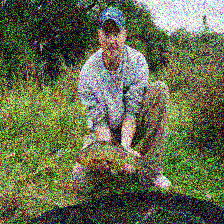

..\imagenette2\train\n01440764\ILSVRC2012_val_00009346.JPEG
incorrect prediction
filename: ILSVRC2012_val_00009346.JPEG
init_pred:0, new_pred:669


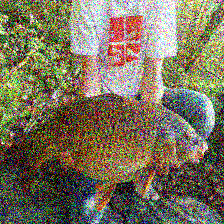

..\imagenette2\train\n01440764\ILSVRC2012_val_00009379.JPEG
incorrect prediction
filename: ILSVRC2012_val_00009379.JPEG
init_pred:0, new_pred:276


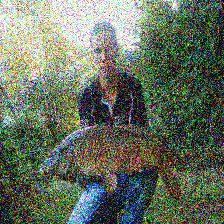

..\imagenette2\train\n01440764\ILSVRC2012_val_00009396.JPEG
incorrect prediction
filename: ILSVRC2012_val_00009396.JPEG
init_pred:0, new_pred:669


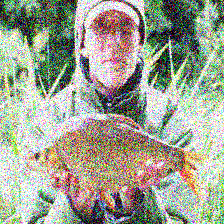

..\imagenette2\train\n01440764\ILSVRC2012_val_00011233.JPEG
incorrect prediction
filename: ILSVRC2012_val_00011233.JPEG
init_pred:0, new_pred:669


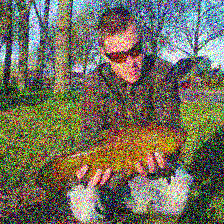

..\imagenette2\train\n01440764\ILSVRC2012_val_00011993.JPEG
incorrect prediction
filename: ILSVRC2012_val_00011993.JPEG
init_pred:0, new_pred:669


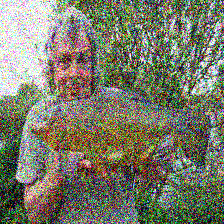

..\imagenette2\train\n01440764\ILSVRC2012_val_00012503.JPEG
incorrect prediction
filename: ILSVRC2012_val_00012503.JPEG
init_pred:0, new_pred:669


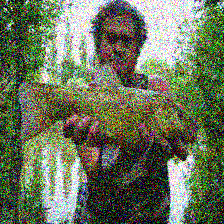

..\imagenette2\train\n01440764\ILSVRC2012_val_00013716.JPEG
incorrect prediction
filename: ILSVRC2012_val_00013716.JPEG
init_pred:0, new_pred:669


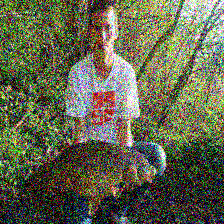

..\imagenette2\train\n01440764\ILSVRC2012_val_00016018.JPEG
incorrect prediction
filename: ILSVRC2012_val_00016018.JPEG
init_pred:0, new_pred:904


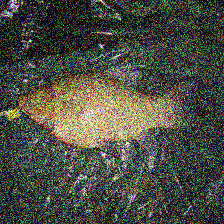

..\imagenette2\train\n01440764\ILSVRC2012_val_00017699.JPEG
incorrect prediction
filename: ILSVRC2012_val_00017699.JPEG
init_pred:0, new_pred:669


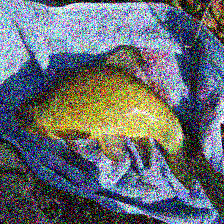

..\imagenette2\train\n01440764\ILSVRC2012_val_00017995.JPEG
incorrect prediction
filename: ILSVRC2012_val_00017995.JPEG
init_pred:0, new_pred:834


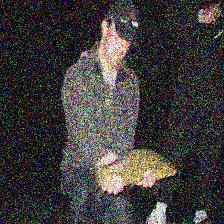

..\imagenette2\train\n01440764\ILSVRC2012_val_00023559.JPEG
incorrect prediction
filename: ILSVRC2012_val_00023559.JPEG
init_pred:0, new_pred:5


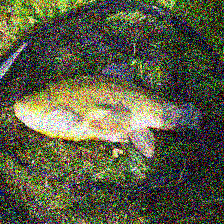

..\imagenette2\train\n01440764\ILSVRC2012_val_00024235.JPEG
incorrect prediction
filename: ILSVRC2012_val_00024235.JPEG
init_pred:0, new_pred:921


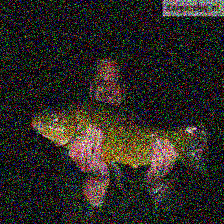

..\imagenette2\train\n01440764\ILSVRC2012_val_00024327.JPEG
incorrect prediction
filename: ILSVRC2012_val_00024327.JPEG
init_pred:0, new_pred:921


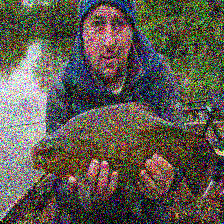

..\imagenette2\train\n01440764\ILSVRC2012_val_00025129.JPEG
incorrect prediction
filename: ILSVRC2012_val_00025129.JPEG
init_pred:0, new_pred:280


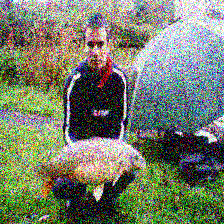

..\imagenette2\train\n01440764\ILSVRC2012_val_00025527.JPEG
incorrect prediction
filename: ILSVRC2012_val_00025527.JPEG
init_pred:0, new_pred:728


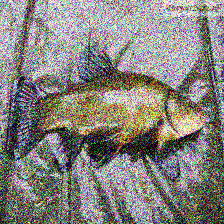

..\imagenette2\train\n01440764\ILSVRC2012_val_00026397.JPEG
incorrect prediction
filename: ILSVRC2012_val_00026397.JPEG
init_pred:0, new_pred:669


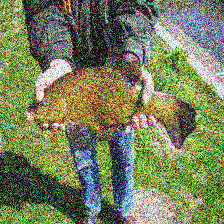

..\imagenette2\train\n01440764\ILSVRC2012_val_00031094.JPEG
incorrect prediction
filename: ILSVRC2012_val_00031094.JPEG
init_pred:0, new_pred:904


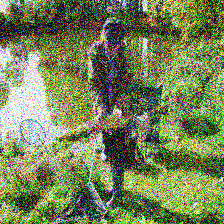

..\imagenette2\train\n01440764\ILSVRC2012_val_00034654.JPEG
incorrect prediction
filename: ILSVRC2012_val_00034654.JPEG
init_pred:0, new_pred:601


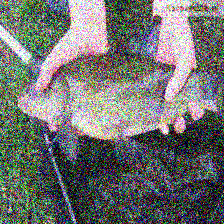

..\imagenette2\train\n01440764\ILSVRC2012_val_00037834.JPEG
incorrect prediction
filename: ILSVRC2012_val_00037834.JPEG
init_pred:0, new_pred:5


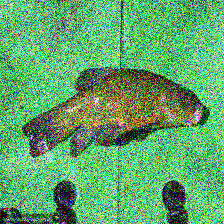

..\imagenette2\train\n01440764\ILSVRC2012_val_00039905.JPEG
correct prediction
filename: ILSVRC2012_val_00039905.JPEG
pred:0
..\imagenette2\train\n01440764\ILSVRC2012_val_00040358.JPEG
incorrect prediction
filename: ILSVRC2012_val_00040358.JPEG
init_pred:0, new_pred:843


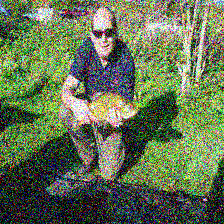

..\imagenette2\train\n01440764\ILSVRC2012_val_00040833.JPEG
incorrect prediction
filename: ILSVRC2012_val_00040833.JPEG
init_pred:0, new_pred:715


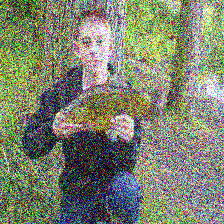

..\imagenette2\train\n01440764\ILSVRC2012_val_00041939.JPEG
incorrect prediction
filename: ILSVRC2012_val_00041939.JPEG
init_pred:0, new_pred:601


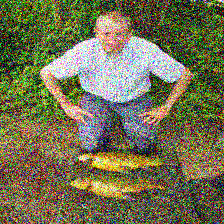

..\imagenette2\train\n01440764\ILSVRC2012_val_00045866.JPEG
incorrect prediction
filename: ILSVRC2012_val_00045866.JPEG
init_pred:0, new_pred:465


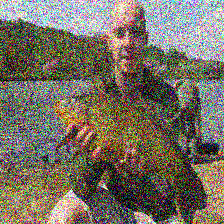

..\imagenette2\train\n01440764\ILSVRC2012_val_00046499.JPEG
incorrect prediction
filename: ILSVRC2012_val_00046499.JPEG
init_pred:0, new_pred:601


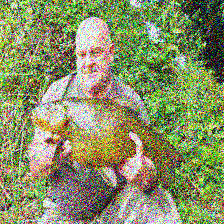

..\imagenette2\train\n01440764\ILSVRC2012_val_00048204.JPEG
incorrect prediction
filename: ILSVRC2012_val_00048204.JPEG
init_pred:0, new_pred:921


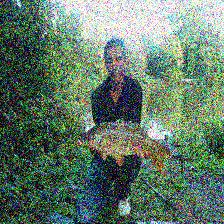

..\imagenette2\train\n01440764\ILSVRC2012_val_00048969.JPEG
incorrect prediction
filename: ILSVRC2012_val_00048969.JPEG
init_pred:0, new_pred:834


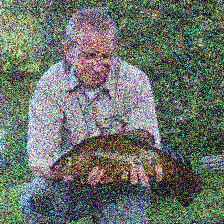

..\imagenette2\train\n01440764\n01440764_10027.JPEG
incorrect prediction
filename: n01440764_10027.JPEG
init_pred:0, new_pred:465


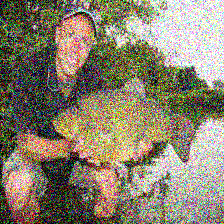

..\imagenette2\train\n01440764\n01440764_10029.JPEG
incorrect prediction
filename: n01440764_10029.JPEG
init_pred:0, new_pred:149


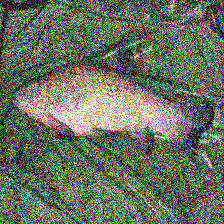

..\imagenette2\train\n01440764\n01440764_10043.JPEG
incorrect prediction
filename: n01440764_10043.JPEG
init_pred:0, new_pred:465


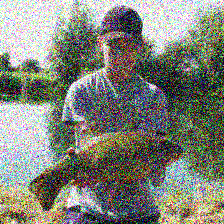

..\imagenette2\train\n01440764\n01440764_10048.JPEG
incorrect prediction
filename: n01440764_10048.JPEG
init_pred:0, new_pred:669


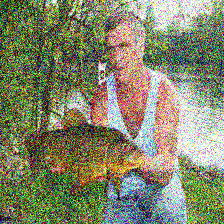

..\imagenette2\train\n01440764\n01440764_10066.JPEG
incorrect prediction
filename: n01440764_10066.JPEG
init_pred:0, new_pred:921


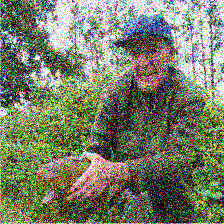

..\imagenette2\train\n01440764\n01440764_10074.JPEG
incorrect prediction
filename: n01440764_10074.JPEG
init_pred:0, new_pred:669


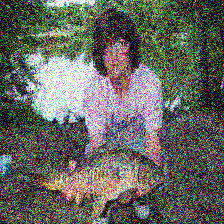

..\imagenette2\train\n01440764\n01440764_10108.JPEG
incorrect prediction
filename: n01440764_10108.JPEG
init_pred:0, new_pred:465


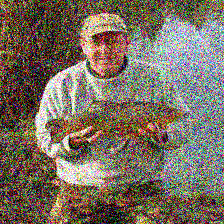

..\imagenette2\train\n01440764\n01440764_10124.JPEG
incorrect prediction
filename: n01440764_10124.JPEG
init_pred:0, new_pred:669


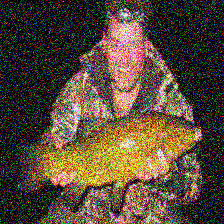

..\imagenette2\train\n01440764\n01440764_10159.JPEG
incorrect prediction
filename: n01440764_10159.JPEG
init_pred:0, new_pred:465


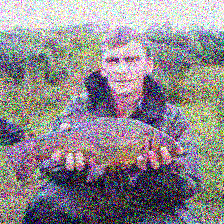

..\imagenette2\train\n01440764\n01440764_10183.JPEG
incorrect prediction
filename: n01440764_10183.JPEG
init_pred:0, new_pred:633


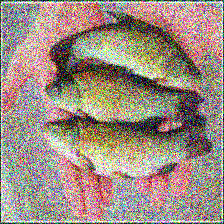

..\imagenette2\train\n01440764\n01440764_10194.JPEG
incorrect prediction
filename: n01440764_10194.JPEG
init_pred:0, new_pred:431


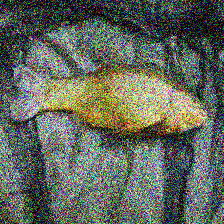

..\imagenette2\train\n01440764\n01440764_10218.JPEG
incorrect prediction
filename: n01440764_10218.JPEG
init_pred:0, new_pred:619


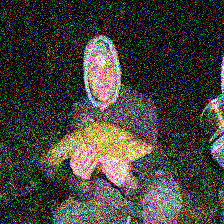

..\imagenette2\train\n01440764\n01440764_10227.JPEG
incorrect prediction
filename: n01440764_10227.JPEG
init_pred:0, new_pred:5


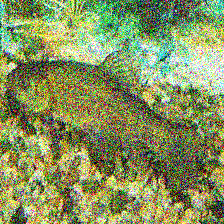

..\imagenette2\train\n01440764\n01440764_10254.JPEG
incorrect prediction
filename: n01440764_10254.JPEG
init_pred:0, new_pred:669


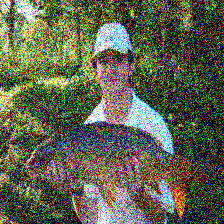

..\imagenette2\train\n01440764\n01440764_10293.JPEG
incorrect prediction
filename: n01440764_10293.JPEG
init_pred:0, new_pred:314


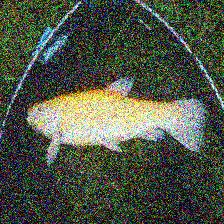

KeyboardInterrupt: 

In [102]:
# create perturbation set
start_time = time.time()
gen_sample_set("..\\imagenette2\\train", 0.25)
elapsed_time = time.time() - start_time
print("std:{}, elapsed_time:{}".format(0.25, elapsed_time))

In [ ]:
print("std:{}, elapsed_time:{}".format(0.25, elapsed_time))

In [ ]:
# create perturbation set
start_time = time.time()
gen_sample_set("..\\imagenette2\\train", 0.5)
elapsed_time = time.time() - start_time
print("std:{}, elapsed_time:{}".format(0.5, elapsed_time))

In [ ]:
print("std:{}, elapsed_time:{}".format(0.25, elapsed_time))